In [544]:
# Import the relevant packages and the store data.  Note this code represents the code ultimately used when
# Building the XGBoost model for the Kaggle Submission. Prior code could not be consolidated given the long lag-times
# it takes for the code to run.

import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

%matplotlib inline

csvf = '/Users/jamieyachera/DAT9/DAT-9-HW/Project/store.csv'
store = pd.read_csv(csvf, sep=',')# index_col='Store')
store.head()

                

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,c,c,620,9,2009,0,NaN,NaN,NaN
4,5,a,a,29910,4,2015,0,NaN,NaN,NaN


In [545]:
# Import the daily sales data
csvf2 = '/Users/jamieyachera/DAT9/DAT-9-HW/Project/train.csv'
train = pd.read_csv(csvf2, sep=',', low_memory=False)#,index_col='Store')
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [546]:
# Import the daily sales data
csvft = '/Users/jamieyachera/DAT9/DAT-9-HW/Project/test.csv'
test= pd.read_csv(csvft, sep=',', low_memory=False)#,index_col='Store')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0
3,4,8,4,2015-09-17,1,1,0,0
4,5,9,4,2015-09-17,1,1,0,0


In [547]:
###########################     MODIFYING STORE VARIABLES   ######################
## Learning about the store variables and adding in new variables
store.dtypes 
store.isnull().sum()

# There are three stores with null Competition Distance
# There are 544 with missing Promo Interval/Since Week/Since Year.  Most likely because the Promotion2 is
#     not applicable to this store
# There are 354 With Competition Open Since Month/ Year is missing



Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [548]:
# Since we need to predict all of the stores, inputting the mean of the competition distance
store.CompetitionOpenSinceYear.fillna(1900, inplace=True)
store.CompetitionOpenSinceMonth.fillna(1, inplace=True)
store.Promo2SinceYear.fillna(1900, inplace=True)
store.Promo2SinceWeek.fillna(1, inplace=True)


In [549]:
m_comp = store.CompetitionDistance.mean()
store.CompetitionDistance.fillna(m_comp, inplace=True)

In [550]:
store.fillna(0, inplace=True)

In [551]:
store.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [552]:
# Remove columns with Sales = 0, Open = 0
train = train[(train['Open']==1)&(train['Sales']>0)]

In [553]:
# Creating competition Open Since Date by taking the first day of the month by default and making into a date-time
store['CompetitionOpenSinceYear'] = store['CompetitionOpenSinceYear'].astype(int)
store['CompetitionOpenSinceMonth'] = store['CompetitionOpenSinceMonth'].astype(int)
store['First'] = int(1)
store['Comp_Date'] = store.apply(lambda row: datetime(row['CompetitionOpenSinceYear'], row['First'], row['CompetitionOpenSinceMonth']), axis=1)
store['Comp_Date'] = pd.to_datetime(store.Comp_Date)

In [554]:
store['CompetitionOpen'] = np.where((store['CompetitionOpenSinceYear']>1900), 1, 0)

In [555]:
# Create a Promo date based on the 1st day of the week for Promotion Week/ Year
# Temporarily creating a null value for now.  Will remove/ replace later

store['Promo_Week']= store.Promo2SinceWeek.astype(int)
store['Promo_Year']= store.Promo2SinceYear.astype(int)

def tofirstdayinisoweek(year, week):
    ret = datetime.strptime('%04d-%02d-1' % (year, week), '%Y-%W-%w')
    if date(year, 1, 4).isoweekday() > 4:
        ret -= timedelta(days=7)
    return ret

Promo_Date = []
for index, row in store.iterrows():
    promodate = tofirstdayinisoweek(row['Promo_Year'], row['Promo_Week'])
    Promo_Date.append(promodate)
store['Promo_Date'] = Promo_Date
store['Promo_Month'] = store['Promo_Date'].dt.month

In [556]:
#Creating a dataframe of the number of Comps opened the same day
Compdf = pd.DataFrame(store.groupby('Comp_Date').Comp_Date.count())
Compdf['Comp_Count']= Compdf['Comp_Date']
Compdf.drop('Comp_Date', axis =1, inplace = True)
Compdf.head()
store = pd.merge(store, Compdf, left_on = 'Comp_Date', right_index = 'Date', how = 'outer')

In [557]:
# Confirming that the new variable has been added to the dataframe
store.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'First',
       u'Comp_Date', u'CompetitionOpen', u'Promo_Week', u'Promo_Year',
       u'Promo_Date', u'Promo_Month', u'Comp_Count'],
      dtype='object')

In [558]:
###########################     MODIFYING TRAIN & TEST VARIABLES   ######################
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [561]:
# Modifying the Date into an actual Date
train['Date']=pd.to_datetime(train.Date)

In [563]:
# Modifying the test Date into an actual Date
test['Date']=pd.to_datetime(test.Date)

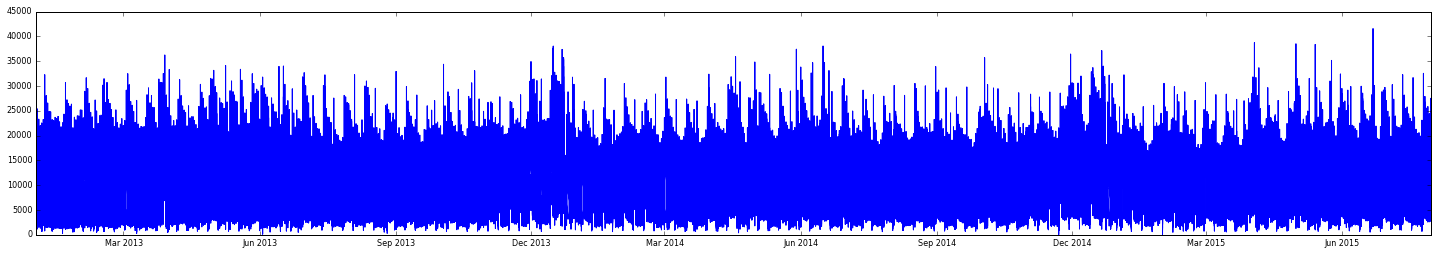

In [564]:
# Looking at sales for all stores
plt.plot(train.Date, train.Sales)

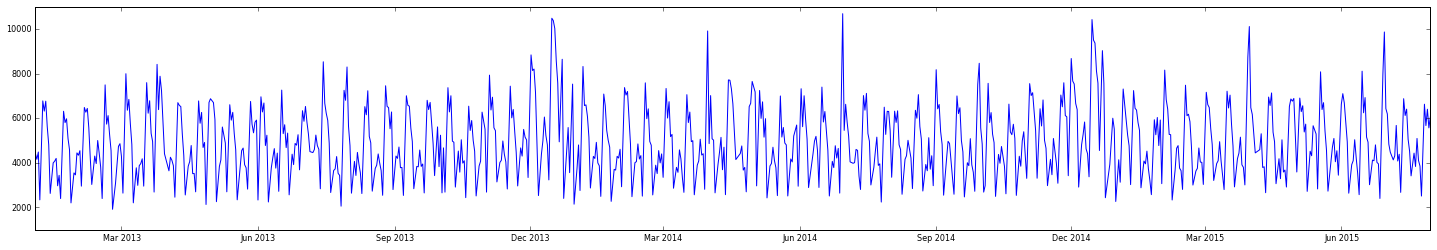

In [565]:
# Looking at sales for one store.  Note the dip in sales each day.
plt.rcParams['figure.figsize'] = (25, 4)
plt.rcParams['font.size'] = 8
y = train[train.Store == 2]
plt.plot(y.Date, y.Sales)

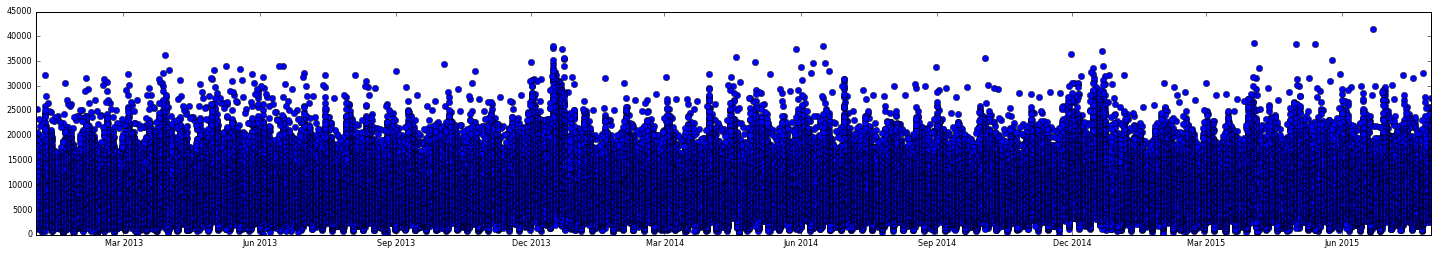

In [566]:
# Using the matplotlib mdates to create a time series plot
import matplotlib.dates as mdates
plt.plot_date(train.Date, train.Sales)

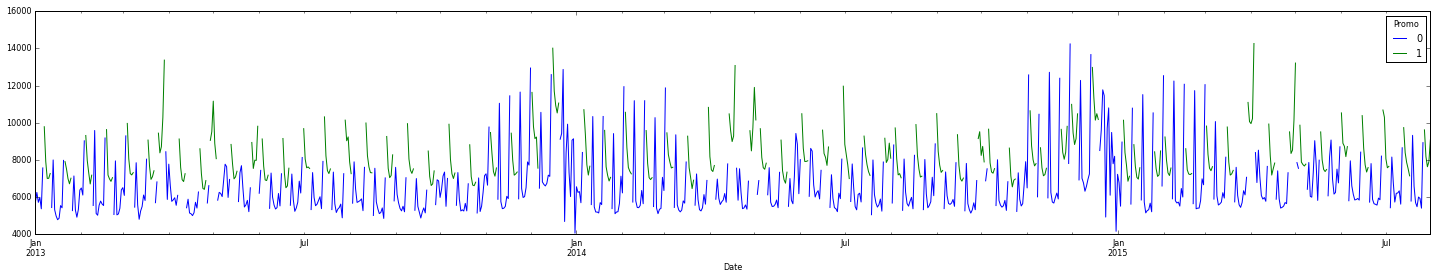

In [567]:
# Note that the stores with a Promotion have higher average sales
train.groupby(['Date','Promo']).Sales.mean().unstack().plot()

In [568]:
# We see that stores with Promos have no Sales on the weekend
train.groupby(['DayOfWeek','Promo']).Sales.mean().unstack()

Promo,0,1
DayOfWeek,,
1,6222.727829,9772.910890
2,5716.412127,8277.630871
3,5617.729043,7685.682535
4,5750.882664,7598.788372
5,6344.411832,7744.388208
6,5875.084935,NaN
7,8224.723908,NaN


In [569]:
# Similarly, we see that stores with Promos have no customers on the weekend
train.groupby(['DayOfWeek','Promo']).Customers.mean().unstack()

Promo,0,1
DayOfWeek,,
1,742.803183,943.435411
2,687.552386,841.499222
3,672.636232,799.267524
4,688.875260,810.204153
5,735.234548,824.726854
6,660.205023,NaN
7,1441.532424,NaN


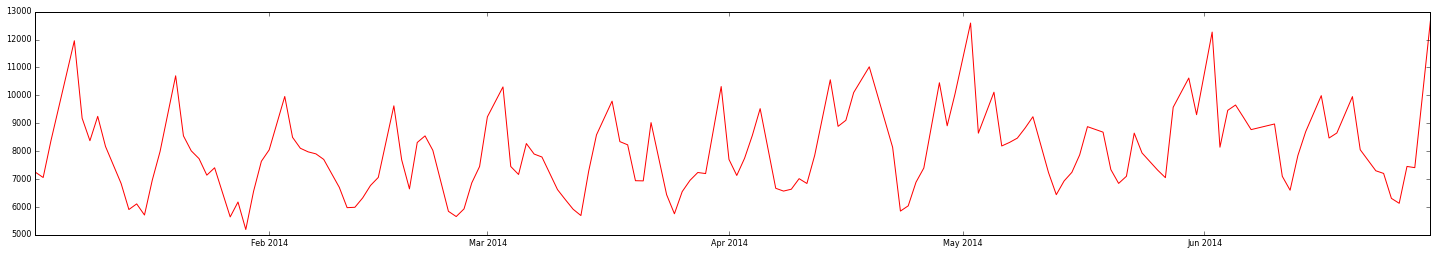

In [570]:
# We see that we are missing data after June 2014 for the remainder of the year for some stores (not the 1/2 above)
Store1 = train[(train.Store == 100) & (train.Date <= '12-01-2014')  &(train.Date >= '1-01-2014')]
plt.plot_date(x = Store1.Date, y = Store1.Sales, fmt="r-")

In [571]:
# We see that we are missing data after June 2014 for the remainder of the year for some stores (not the 1/2 above)
# 180 stores are missing a few months of data
missing = (train[(train.Date == '12-31-2013')].count()) -(train[(train.Date == '12-31-2014')].count())
missing

Store            180
DayOfWeek        180
Date             180
Sales            180
Customers        180
Open             180
Promo            180
StateHoliday     180
SchoolHoliday    180
dtype: int64

In [572]:
# Creating variables for the sale month and sale week
train['Sale_Month'] = train['Date'].dt.month
train['Sale_Week'] = train['Date'].dt.weekofyear

test['Sale_Month'] = test['Date'].dt.month
test['Sale_Week'] = test['Date'].dt.weekofyear

In [573]:
# Calculating Cumulative Sales and Cumulative number of Customers
train = train.sort(['Store', 'Date'])
Cum_Sales = []
Cum_Cust = []
sale = 0
cust = 0
s = 1
for index, row in train.iterrows():
    if row['Store'] == s:
        sale = sale + row['Sales']
        cust = cust + row['Customers']
        Cum_Sales.append(sale)
        Cum_Cust.append(cust)
    else:
        s = s + 1
        sale = row['Sales']
        cust = row['Customers']
        Cum_Sales.append(sale)
        Cum_Cust.append(cust)
        
train['Cum_Sales']= Cum_Sales
train['Cum_Cust'] = Cum_Cust

In [574]:
# Test data does not have Sales/ Customers

In [575]:
# Creating the average sales per customer.  Replacing NaN with 0
train['Avg_Cust_Sales'] = train['Cum_Sales']/train['Cum_Cust'] 
train.Avg_Cust_Sales.fillna(value=0, inplace=True) 

In [576]:
# Merging the Data Set for Calculations
train.head()
store.head()
#train = train.set_index('Store')
train = pd.merge(store, train, right_on='Store', left_on='Store')
train.shape

(844338, 31)

In [577]:
# Merging the Data Set for Calculations
test.head()
store.head()
#train = train.set_index('Store')
test = pd.merge(store, test, right_on='Store', left_on='Store')
test.shape

(41088, 27)

In [578]:
# Evaluating Merged dataset

In [579]:
# Reviewing Store Type and Assortment
train.groupby(['StoreType','Assortment']).Sales.mean()
# StoreType 'b' has significantly more sales; Assortment 'b' is only in StoreType b.  
# Assortment 'c' generally has higher sales

StoreType  Assortment
a          a              6538.189027
           c              7573.822775
b          a             11133.992979
           b              8642.503594
           c             17969.556263
c          a              6835.748557
           c              7037.913129
d          a              6433.756093
           c              7043.534764
Name: Sales, dtype: float64

In [580]:
# Weekdays have higher sales than weekends
new = pd.DataFrame(train.groupby(['DayOfWeek']).Sales.mean())
new

,Sales
DayOfWeek,
1,8216.252259
2,7088.409086
3,6728.786679
4,6768.214973
5,7073.034133
6,5875.084935
7,8224.723908


In [581]:
# Evaluating Sale Week
new = train.groupby(['Sale_Week'])['Sales', 'Cum_Sales', 'Customers'].mean()
new = new.sort('Sales')
new

,Sales,Cum_Sales,Customers
Sale_Week,,,
42,5515.545102,2585664.539600,675.515897
11,5633.235520,2435867.049405,670.918223
30,5638.504625,3203592.419426,664.950279
7,5692.554968,2281382.589451,682.753930
26,5788.437745,3033792.082907,675.725285
9,5845.255711,2351927.639775,688.955606
28,5943.296822,3124485.689519,696.678855
3,5972.461976,2121609.773104,684.988273
24,5987.047669,2956316.219866,700.252415


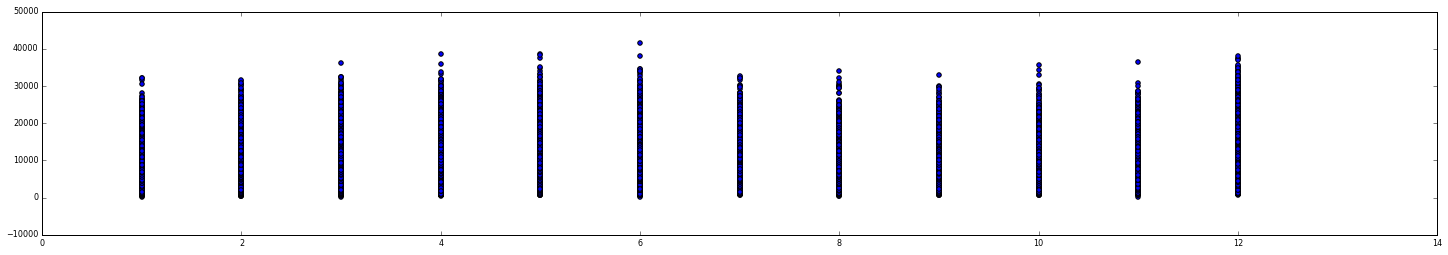

In [582]:
train.groupby(['Sale_Month'])['Sales', 'Cum_Sales', 'Customers'].mean()
# July and December have the highest sales, customers
plt.scatter(train.Sale_Month, train.Sales)

In [583]:
# Looking at how the PromoIntervals impact Sales.  Only slightly higher for those that start in the beginning of the Year
train[train.Promo == 1].groupby(['PromoInterval'])['Sales', 'Cum_Sales', 'Customers'].mean()

,Sales,Cum_Sales,Customers
PromoInterval,,,
0,8618.452062,2865654.278897,928.608751
"Feb,May,Aug,Nov",7752.467859,2430068.379876,747.391669
"Jan,Apr,Jul,Oct",8027.613514,2451834.936801,775.588005
"Mar,Jun,Sept,Dec",7367.540281,2369793.626968,727.866656


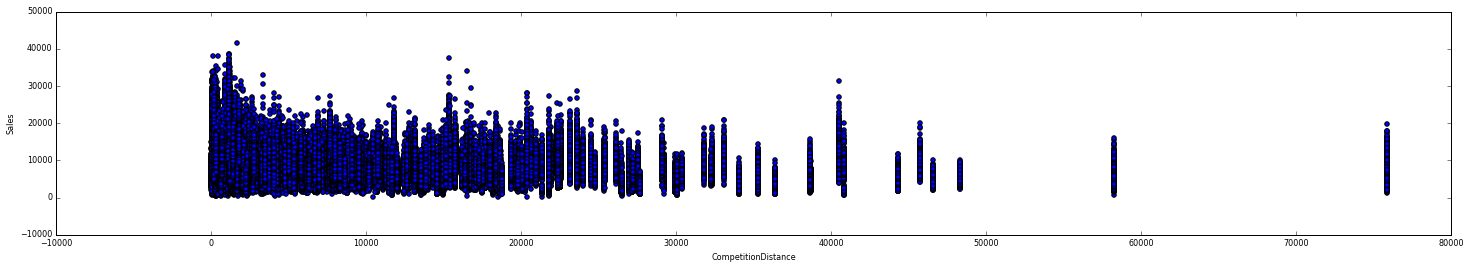

In [584]:
# Those with very close competition still have higher sales than we would expect
train.plot(kind='scatter', x='CompetitionDistance', y='Sales')

In [585]:
new = train.groupby('Store')['Sales', 'CompetitionDistance'].mean()
new = new.sort('Sales')
new
# Here we see that there are stores with a significant amount of sales (aka Store 198 and 208) 
# that has nearby competition

,Sales,CompetitionDistance
Store,,
307,2703.736573,18660
543,2790.380282,1080
198,2900.604859,290
208,2936.290816,300
841,2972.608974,27650
254,3005.983312,330
794,3083.812821,5090
219,3133.712452,1640
210,3193.984596,970


In [586]:
# Looking at the distribution of Competition Distance to see what really is 'close'
train.CompetitionDistance.describe()

count    844338.000000
mean       5458.018748
std        7799.457552
min          20.000000
25%         710.000000
50%        2330.000000
75%        6880.000000
max       75860.000000
Name: CompetitionDistance, dtype: float64

In [587]:
# Stores with Promos have higher sales
train.groupby('Promo').Sales.mean()

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64

In [588]:
# Creating Date Differences

train['Sale_Since_Comp_Opened'] = train['Date']-train['Comp_Date']
train['Sale_Since_Comp_Opened']
train['Sale_Since_Promo_Started'] = train['Date']-train['Promo_Date']
train.drop('First', axis=1, inplace = True)

In [589]:
# Creating Date Differences

test['Sale_Since_Comp_Opened'] = test['Date']-test['Comp_Date']
test['Sale_Since_Comp_Opened']
test['Sale_Since_Promo_Started'] = train['Date']-test['Promo_Date']
test.drop('First', axis=1, inplace = True)

In [590]:
# New school/holiday flags based on school/holiday
train.groupby('StateHoliday').mean()
train.groupby(['StateHoliday','SchoolHoliday']).mean()
train['SchoolHoliday2'] = np.where(train['StateHoliday']=='a','1', train['SchoolHoliday'])
test['SchoolHoliday2'] = np.where(test['StateHoliday']=='a','1', test['SchoolHoliday'])



In [591]:
# Making a weekend flag.  6= Friday, 7= Saturday
#df[['DayOfWeek','Date']].head(10)
train['Weekend']=np.where(train['DayOfWeek']=={'6','7'},'1','0').astype(int)
test['Weekend']=np.where(test['DayOfWeek']=={'6','7'},'1','0').astype(int)

In [592]:
# Making dummy variables for alphabetic categories (train)
StoreType_dummies = pd.get_dummies(train.StoreType, prefix='StoreType')
StoreType_dummies.drop(StoreType_dummies.columns[0], axis=1, inplace=True)
train = pd.concat([train, StoreType_dummies], axis=1)

Assortment_dummies = pd.get_dummies(train.Assortment, prefix='Assortment')
Assortment_dummies.drop(Assortment_dummies.columns[0], axis=1, inplace=True)
train = pd.concat([train, Assortment_dummies], axis=1)

StateHoliday_dummies = pd.get_dummies(train.StateHoliday, prefix='StateHoliday')
StateHoliday_dummies.drop(StateHoliday_dummies.columns[0], axis=1, inplace=True)
train = pd.concat([train, StateHoliday_dummies], axis = 1)

PromoInterval_dummies = pd.get_dummies(train.PromoInterval, prefix='PromoInterval')
PromoInterval_dummies.drop(PromoInterval_dummies.columns[0], axis=1, inplace=True)
train = pd.concat([train, PromoInterval_dummies], axis = 1)



In [593]:
# Making dummy variables for alphabetic categories (test)
StoreType_dummies = pd.get_dummies(test.StoreType, prefix='StoreType')
StoreType_dummies.drop(StoreType_dummies.columns[0], axis=1, inplace=True)
test = pd.concat([test, StoreType_dummies], axis=1)

Assortment_dummies = pd.get_dummies(test.Assortment, prefix='Assortment')
Assortment_dummies.drop(Assortment_dummies.columns[0], axis=1, inplace=True)
test = pd.concat([test, Assortment_dummies], axis=1)

StateHoliday_dummies = pd.get_dummies(test.StateHoliday, prefix='StateHoliday')
StateHoliday_dummies.drop(StateHoliday_dummies.columns[0], axis=1, inplace=True)
test = pd.concat([test, StateHoliday_dummies], axis = 1)

PromoInterval_dummies = pd.get_dummies(test.PromoInterval, prefix='PromoInterval')
PromoInterval_dummies.drop(PromoInterval_dummies.columns[0], axis=1, inplace=True)
test = pd.concat([test, PromoInterval_dummies], axis = 1)



In [594]:
# Converting days into integers for "Sale Since Promo Started" and "Sale Since Comp Opened"
train['SSPS']=(train.Sale_Since_Promo_Started / np.timedelta64(1, 'D')).astype(int)
train['SSPS']=np.where(train['SSPS']<=0,0, train['SSPS'])
train['SSCO']=(train.Sale_Since_Comp_Opened / np.timedelta64(1, 'D')).astype(int)
train['SSCO']=np.where(train['SSCO']<=0,0, train['SSCO'])

In [595]:
# Converting days into integers for "Sale Since Promo Started" and "Sale Since Comp Opened"
test['SSPS']=(test.Sale_Since_Promo_Started / np.timedelta64(1, 'D')).astype(int)
test['SSPS']=np.where(test['SSPS']<=0,0, test['SSPS'])
test['SSCO']=(test.Sale_Since_Comp_Opened / np.timedelta64(1, 'D')).astype(int)
test['SSCO']=np.where(test['SSCO']<=0,0, test['SSCO'])

In [596]:
# Creating a variable whether Competition Opened within the year
train['CompOpenedInYear'] = np.where((train['SSCO']>0) & (train['SSCO']<=365), 1, 0)
test['CompOpenedInYear'] = np.where((test['SSCO']>0) & (test['SSCO']<=365), 1, 0)



In [597]:
## TRYING SIMPLE WAY:
columns = ['Store', 'DayOfWeek', 'Promo']
medians = train.groupby( columns )['Sales'].median()
medians = medians.reset_index()
medians['Sales_new'] = medians['Sales']
medians.drop('Sales', axis=1, inplace = True)  

In [598]:
medians.head()

,Store,DayOfWeek,Promo,Sales_new
0,1,1,0,4004.0
1,1,1,1,5683.5
2,1,2,0,3773.0
3,1,2,1,5275.5
4,1,3,0,3805.0


In [599]:
# Merging train and median data
train = pd.merge( train, medians, on = columns, how = 'left' )
train[['Store', 'DayOfWeek', 'Promo', 'Sales_new', 'Sales']].head(10)

,Store,DayOfWeek,Promo,Sales_new,Sales
0,1,3,0,3805.0,5530
1,1,4,0,3810.5,4327
2,1,5,0,4130.5,4486
3,1,6,0,4785.0,4997
4,1,1,1,5683.5,7176
5,1,2,1,5275.5,5580
6,1,3,1,4957.0,5471
7,1,4,1,4770.5,4892
8,1,5,1,4986.0,4881
9,1,6,0,4785.0,4952


In [600]:
# Merging test and median data
test = pd.merge( test, medians, on = columns, how = 'left' )

In [601]:
# Adding Median of Avg Cust Sales for each of the store combinations to the train/ test set
medians = train.groupby( columns )['Avg_Cust_Sales'].median()
medians = medians.reset_index()
medians['Avg_Cust_Sales_new'] = medians['Avg_Cust_Sales']
medians.drop('Avg_Cust_Sales', axis=1, inplace = True)  
test = pd.merge( test, medians, on = columns, how = 'left' )
train = pd.merge( train, medians, on = columns, how = 'left' )

In [602]:
# Adding Median of Avg Cust Sales for each of the store combinations to the train/ test set
medians = train.groupby( columns )['Cum_Sales'].max()
medians = medians.reset_index()
medians['Cum_Sales_new'] = medians['Cum_Sales']
medians.drop('Cum_Sales', axis=1, inplace = True)  
test = pd.merge( test, medians, on = columns, how = 'left' )
train = pd.merge( train, medians, on = columns, how = 'left' )

In [603]:
# Adding Median of Customers Sales for each of the store combinations to the train/ test set
medians = train.groupby( columns )['Customers'].median()
medians = medians.reset_index()
medians['Customers_new'] = medians['Customers']
medians.drop('Customers', axis=1, inplace = True)  
test = pd.merge( test, medians, on = columns, how = 'left' )
train = pd.merge( train, medians, on = columns, how = 'left' )

In [604]:
# Pickle Method of exporting the dataset.  Done in case my computer crashed
train.to_pickle('/Users/jamieyachera/DAT9/DAT-9-HW/Project/train_modified.csv')

In [605]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [606]:
# Building Model using different sets of features
feature_cols0 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 
                'Promo2', 'Comp_Count','Sale_Month', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
                'SSPS', 'SSCO', 'CompetitionDistance', 'CompOpenedInYear']

feature_cols1 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                  'Promo2', 'Comp_Count','Sale_Month', 'SchoolHoliday2',
              'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c','CompetitionDistance', 'CompOpenedInYear']
    
feature_cols2 = ['DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 
                 'Promo2', 'Comp_Count','Sale_Month', 
              'SchoolHoliday2']

feature_cols3 = ['DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 
                 'Promo2', 'Comp_Count','Sale_Month', 
              'SchoolHoliday2', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'SSPS', 'SSCO', 'Customers', 'Open',
                'Sale_Week', 'Cum_Sales', 'Weekend'] 

feature_cols4 = ['StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'Promo2', 'Sale_Month', 
              'SchoolHoliday2', 'Weekend']

feature_cols5 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'Promo2', 'Comp_Count','Sale_Month', 
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'CompOpenedInYear']

feature_cols6 = ['DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c', 'Promo2', 'Comp_Count','Sale_Month', 
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'CompOpenedInYear']

feature_cols7 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                 'Promo2', 'Comp_Count','Sale_Week', 
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'CompOpenedInYear']
    
feature_cols8 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                 'Promo2', 'Comp_Count','Sale_Week', 'Sale_Month',
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'CompOpenedInYear']

feature_cols9 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                 'Promo2', 'Sale_Month', 
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompetitionDistance', 'CompOpenedInYear']
    
feature_cols10 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                  'Promo2', 'Sale_Month', 
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'CompOpenedInYear']

feature_cols11 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                  'Sale_Month', 'Promo',
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c']
    
feature_cols12 = ['Store', 'DayOfWeek', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b', 'Assortment_c',
                  'Sale_Month', 'Promo',
              'SchoolHoliday2','StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'Avg_Cust_Sales']
               
feature_cols13 = ['Store', 'DayOfWeek', 'Sales_new','Sale_Month', 'Promo']

feature_cols = [feature_cols0, feature_cols1, feature_cols2, feature_cols3, feature_cols4, feature_cols5, feature_cols6,
               feature_cols7, feature_cols8, feature_cols9, feature_cols10, feature_cols11, feature_cols12, feature_cols13]

In [607]:
feature_full = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Customers', 'Open',
       'Promo', 'Sale_Month',
       'Sale_Week', 'Cum_Sales', 'Cum_Cust', 'Avg_Cust_Sales', 'Weekend',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec', 'SSPS', 'SSCO',
       'CompOpenedInYear']

In [608]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          #"subsample": 0.9, 
          #"colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1
          }
num_boost_round = 300

# http://xgboost.readthedocs.org/en/latest/parameter.html

In [124]:
import xgboost as xgb 
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[feature_full], y_train)
dvalid = xgb.DMatrix(X_valid[feature_full], y_valid)

In [127]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996931	eval-rmspe:0.996915
[1]	train-rmspe:0.982195	eval-rmspe:0.982120
[2]	train-rmspe:0.940320	eval-rmspe:0.940116
[3]	train-rmspe:0.861043	eval-rmspe:0.860647
[4]	train-rmspe:0.749104	eval-rmspe:0.748503
[5]	train-rmspe:0.620898	eval-rmspe:0.620157
[6]	train-rmspe:0.493814	eval-rmspe:0.492960
[7]	train-rmspe:0.380664	eval-rmspe:0.379744
[8]	train-rmspe:0.287088	eval-rmspe:0.286253
[9]	train-rmspe:0.214658	eval-rmspe:0.213976
[10]	train-rmspe:0.160462	eval-rmspe:0.159874
[11]	train-rmspe:0.122022	eval-rmspe:0.121648
[12]	train-rmspe:0.096247	eval-rmspe:0.096081
[13]	train-rmspe:0.079573	eval-rmspe:0.079829
[14]	train-rmspe:0.069776	eval-rmspe:0.070346
[15]	train-rmspe:0.064501	eval-rmspe:0.065299
[16]	train-rmspe:0.061501	eval-rmspe:0.062537
[17]	train-rmspe:0.059925	eval-rmspe:0.061151
[18]	train-rmspe:0.058978	eval-rmspe:0.060360
[19]	train-rmspe:0.058249	eval-rmspe:0.059822
[20]	train-rmspe:0.057958	eval

In [129]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[feature_full]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.051975


In [131]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
# https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2/code
import operator
create_feature_map(feature_full)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

In [132]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

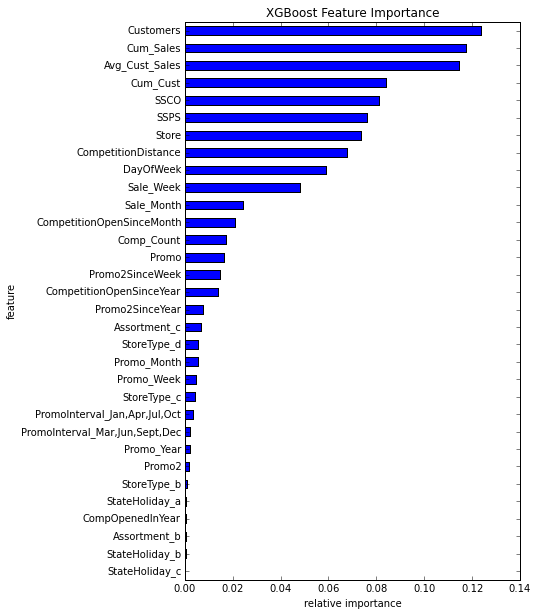

In [133]:
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [138]:
# Reformatting with the best features:
features = ['Customers', 'Cum_Sales', 'Avg_Cust_Sales', 'Cum_Cust', 'SSCO', 'SSPS',
       'Store', 'CompetitionDistance', 'DayOfWeek', 'Sale_Week']

In [139]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "silent": 1,
          "seed": 1
          }
num_boost_round = 300

# http://xgboost.readthedocs.org/en/latest/parameter.html

In [140]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

In [141]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996932	eval-rmspe:0.996928
[1]	train-rmspe:0.982226	eval-rmspe:0.982206
[2]	train-rmspe:0.940450	eval-rmspe:0.940396
[3]	train-rmspe:0.861344	eval-rmspe:0.861246
[4]	train-rmspe:0.749434	eval-rmspe:0.749286
[5]	train-rmspe:0.620924	eval-rmspe:0.620733
[6]	train-rmspe:0.493791	eval-rmspe:0.493606
[7]	train-rmspe:0.380796	eval-rmspe:0.380627
[8]	train-rmspe:0.287995	eval-rmspe:0.287880
[9]	train-rmspe:0.216348	eval-rmspe:0.216336
[10]	train-rmspe:0.164023	eval-rmspe:0.164174
[11]	train-rmspe:0.127898	eval-rmspe:0.128229
[12]	train-rmspe:0.103974	eval-rmspe:0.104545
[13]	train-rmspe:0.088997	eval-rmspe:0.089815
[14]	train-rmspe:0.078438	eval-rmspe:0.079547
[15]	train-rmspe:0.073221	eval-rmspe:0.074494
[16]	train-rmspe:0.069311	eval-rmspe:0.070785
[17]	train-rmspe:0.067553	eval-rmspe:0.069157
[18]	train-rmspe:0.066725	eval-rmspe:0.068438
[19]	train-rmspe:0.065525	eval-rmspe:0.067377
[20]	train-rmspe:0.064923	eval

In [143]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

# Note that including less features increased the model's score

RMSPE: 0.054747


In [145]:
features = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Customers', 
       'Promo', 'Sale_Month',
       'Sale_Week', 'Cum_Sales', 'Cum_Cust', 'Avg_Cust_Sales', 'SSPS', 'SSCO',
       'CompOpenedInYear']
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996933	eval-rmspe:0.996929
[1]	train-rmspe:0.982238	eval-rmspe:0.982220
[2]	train-rmspe:0.940508	eval-rmspe:0.940460
[3]	train-rmspe:0.861501	eval-rmspe:0.861416
[4]	train-rmspe:0.749692	eval-rmspe:0.749588
[5]	train-rmspe:0.621170	eval-rmspe:0.621062
[6]	train-rmspe:0.493762	eval-rmspe:0.493675
[7]	train-rmspe:0.380163	eval-rmspe:0.380103
[8]	train-rmspe:0.286362	eval-rmspe:0.286356
[9]	train-rmspe:0.213298	eval-rmspe:0.213365
[10]	train-rmspe:0.159071	eval-rmspe:0.159240
[11]	train-rmspe:0.120626	eval-rmspe:0.120956
[12]	train-rmspe:0.094796	eval-rmspe:0.095329
[13]	train-rmspe:0.078388	eval-rmspe:0.079154
[14]	train-rmspe:0.068780	eval-rmspe:0.069766
[15]	train-rmspe:0.063338	eval-rmspe:0.064535
[16]	train-rmspe:0.060430	eval-rmspe:0.061820
[17]	train-rmspe:0.058708	eval-rmspe:0.060259
[18]	train-rmspe:0.057838	eval-rmspe:0.059547
[19]	train-rmspe:0.057238	eval-rmspe:0.059067
[20]	train-rmspe:0.057083	eval

In [146]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.052468


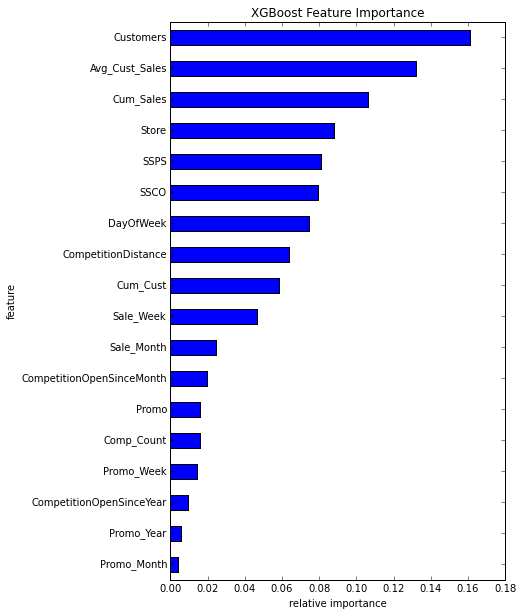

In [148]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [153]:
features = ['Customers', 'Avg_Cust_Sales', 'Cum_Sales', 'Store', 'SSPS', 
            'SSCO', 'DayOfWeek', 'CompetitionDistance', 'Cum_Cust', 
            'Sale_Week', 'Sale_Month', 'CompetitionOpenSinceMonth', 'Promo', 'Comp_Count', 'Promo_Week',
            'CompetitionOpenSinceYear', 'Promo_Year', 'Promo_Month']
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996933	eval-rmspe:0.996929
[1]	train-rmspe:0.982238	eval-rmspe:0.982220
[2]	train-rmspe:0.940508	eval-rmspe:0.940460
[3]	train-rmspe:0.861501	eval-rmspe:0.861416
[4]	train-rmspe:0.749692	eval-rmspe:0.749588
[5]	train-rmspe:0.621170	eval-rmspe:0.621062
[6]	train-rmspe:0.493762	eval-rmspe:0.493675
[7]	train-rmspe:0.380163	eval-rmspe:0.380103
[8]	train-rmspe:0.286362	eval-rmspe:0.286356
[9]	train-rmspe:0.213298	eval-rmspe:0.213365
[10]	train-rmspe:0.159071	eval-rmspe:0.159240
[11]	train-rmspe:0.120626	eval-rmspe:0.120955
[12]	train-rmspe:0.094796	eval-rmspe:0.095329
[13]	train-rmspe:0.078388	eval-rmspe:0.079154
[14]	train-rmspe:0.068780	eval-rmspe:0.069768
[15]	train-rmspe:0.063338	eval-rmspe:0.064539
[16]	train-rmspe:0.060430	eval-rmspe:0.061824
[17]	train-rmspe:0.058708	eval-rmspe:0.060263
[18]	train-rmspe:0.057838	eval-rmspe:0.059551
[19]	train-rmspe:0.057238	eval-rmspe:0.059071
[20]	train-rmspe:0.057083	eval

In [154]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.052487


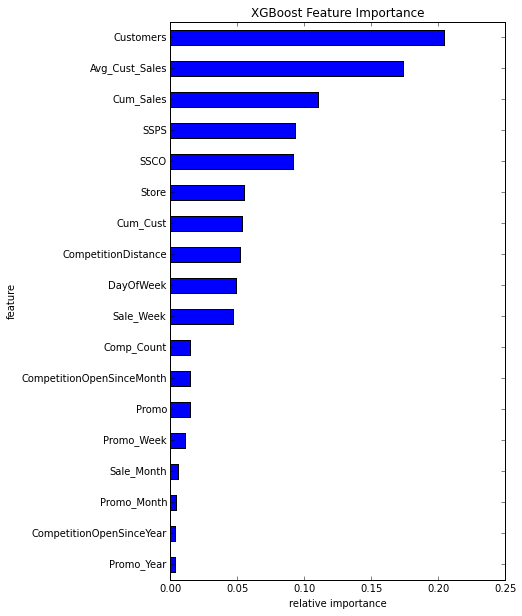

In [155]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [160]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "silent": 1,
          "seed": 1
          }
num_boost_round = 100

X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[feature_cols13], y_train)
dvalid = xgb.DMatrix(X_valid[feature_cols13], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 50 rounds.
[0]	train-rmspe:0.996921	eval-rmspe:0.996916
[1]	train-rmspe:0.982135	eval-rmspe:0.982110
[2]	train-rmspe:0.940133	eval-rmspe:0.940063
[3]	train-rmspe:0.860793	eval-rmspe:0.860697
[4]	train-rmspe:0.749197	eval-rmspe:0.749226
[5]	train-rmspe:0.622580	eval-rmspe:0.623136
[6]	train-rmspe:0.499886	eval-rmspe:0.501845
[7]	train-rmspe:0.395281	eval-rmspe:0.399792
[8]	train-rmspe:0.314259	eval-rmspe:0.323987
[9]	train-rmspe:0.259716	eval-rmspe:0.274920
[10]	train-rmspe:0.227023	eval-rmspe:0.248107
[11]	train-rmspe:0.210242	eval-rmspe:0.235585
[12]	train-rmspe:0.203276	eval-rmspe:0.231554
[13]	train-rmspe:0.201153	eval-rmspe:0.231687
[14]	train-rmspe:0.201297	eval-rmspe:0.233832
[15]	train-rmspe:0.202068	eval-rmspe:0.235426
[16]	train-rmspe:0.202973	eval-rmspe:0.237155
[17]	train-rmspe:0.203848	eval-rmspe:0.238285
[18]	train-rmspe:0.204363	eval-rmspe:0.239033
[19]	train-rmspe:0.204823	eval-rmspe:0.240143
[20]	train-rmspe:0.205119	eval-

RMSPE: 0.242682


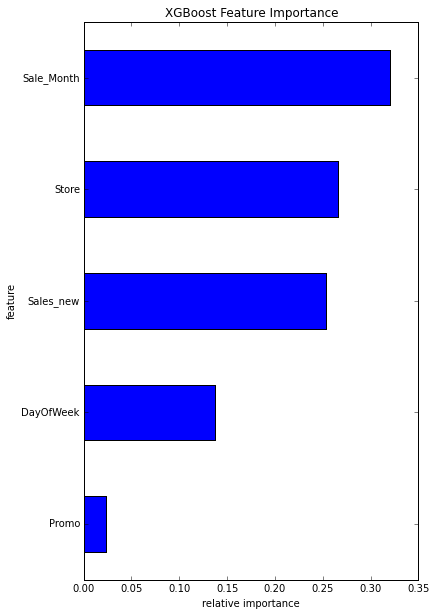

In [166]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[feature_cols13]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

create_feature_map(feature_cols13)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [169]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log(X_train.Sales)
y_valid = np.log(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[feature_cols13], y_train)
dvalid = xgb.DMatrix(X_valid[feature_cols13], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 50 rounds.
[0]	train-rmspe:0.996921	eval-rmspe:0.996916
[1]	train-rmspe:0.982133	eval-rmspe:0.982108
[2]	train-rmspe:0.940131	eval-rmspe:0.940060
[3]	train-rmspe:0.860795	eval-rmspe:0.860694
[4]	train-rmspe:0.749222	eval-rmspe:0.749233
[5]	train-rmspe:0.622668	eval-rmspe:0.623174
[6]	train-rmspe:0.500089	eval-rmspe:0.501947
[7]	train-rmspe:0.395678	eval-rmspe:0.400001
[8]	train-rmspe:0.314870	eval-rmspe:0.324346
[9]	train-rmspe:0.260630	eval-rmspe:0.275453
[10]	train-rmspe:0.228223	eval-rmspe:0.248800
[11]	train-rmspe:0.211673	eval-rmspe:0.236395
[12]	train-rmspe:0.204864	eval-rmspe:0.232440
[13]	train-rmspe:0.202822	eval-rmspe:0.232602
[14]	train-rmspe:0.203074	eval-rmspe:0.234849
[15]	train-rmspe:0.203905	eval-rmspe:0.236476
[16]	train-rmspe:0.204790	eval-rmspe:0.238243
[17]	train-rmspe:0.205406	eval-rmspe:0.239407
[18]	train-rmspe:0.205853	eval-rmspe:0.240219
[19]	train-rmspe:0.206257	eval-rmspe:0.241341
[20]	train-rmspe:0.206633	eval-

RMSPE: 0.242074


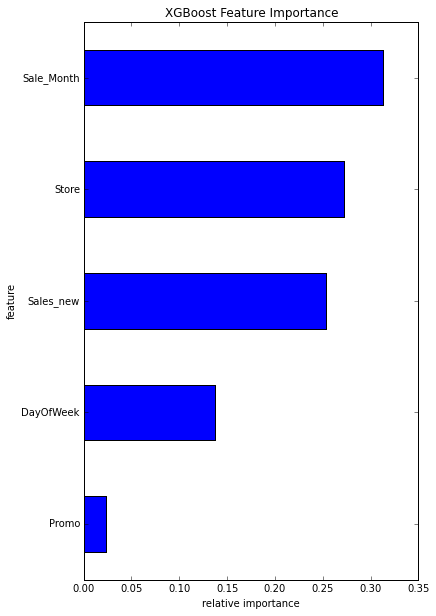

In [175]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[feature_cols13]))
error = rmspe(X_valid.Sales.values, np.exp(yhat))
print('RMSPE: {:.6f}'.format(error))

create_feature_map(feature_cols13)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [176]:
num_boost_round = 100
features = ['Customers', 'Avg_Cust_Sales', 'Cum_Sales', 'Store', 'SSPS', 
            'SSCO', 'DayOfWeek', 'CompetitionDistance', 'Cum_Cust', 
            'Sale_Week', 'Sale_Month', 'CompetitionOpenSinceMonth', 'Promo', 'Comp_Count', 'Promo_Week',
            'CompetitionOpenSinceYear', 'Promo_Year', 'Promo_Month']
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996933	eval-rmspe:0.996929
[1]	train-rmspe:0.982238	eval-rmspe:0.982220
[2]	train-rmspe:0.940508	eval-rmspe:0.940460
[3]	train-rmspe:0.861501	eval-rmspe:0.861416
[4]	train-rmspe:0.749692	eval-rmspe:0.749588
[5]	train-rmspe:0.621170	eval-rmspe:0.621062
[6]	train-rmspe:0.493762	eval-rmspe:0.493675
[7]	train-rmspe:0.380163	eval-rmspe:0.380103
[8]	train-rmspe:0.286362	eval-rmspe:0.286356
[9]	train-rmspe:0.213298	eval-rmspe:0.213365
[10]	train-rmspe:0.159071	eval-rmspe:0.159240
[11]	train-rmspe:0.120626	eval-rmspe:0.120955
[12]	train-rmspe:0.094796	eval-rmspe:0.095329
[13]	train-rmspe:0.078388	eval-rmspe:0.079154
[14]	train-rmspe:0.068780	eval-rmspe:0.069768
[15]	train-rmspe:0.063338	eval-rmspe:0.064539
[16]	train-rmspe:0.060430	eval-rmspe:0.061824
[17]	train-rmspe:0.058708	eval-rmspe:0.060263
[18]	train-rmspe:0.057838	eval-rmspe:0.059551
[19]	train-rmspe:0.057238	eval-rmspe:0.059071
[20]	train-rmspe:0.057083	eval

In [178]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.exp(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.053993


In [185]:
test.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Comp_Date',
       u'Promo_Week', u'Promo_Year', u'Promo_Date', u'Promo_Month',
       u'Comp_Count', u'Id', u'DayOfWeek', u'Date', u'Open', u'Promo',
       u'StateHoliday', u'SchoolHoliday', u'Sale_Month', u'Sale_Week',
       u'Sale_Since_Comp_Opened', u'Sale_Since_Promo_Started',
       u'SchoolHoliday2', u'Weekend', u'StoreType_b', u'StoreType_c',
       u'StoreType_d', u'Assortment_b', u'Assortment_c', u'StateHoliday_a',
       u'PromoInterval_Feb,May,Aug,Nov', u'PromoInterval_Jan,Apr,Jul,Oct',
       u'PromoInterval_Mar,Jun,Sept,Dec', u'SSPS', u'SSCO',
       u'CompOpenedInYear', u'Sales_new', u'Avg_Cust_Sales_new',
       u'Cum_Sales_new', u'Customers_new'],
      dtype='object')

In [186]:
features = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Open',
       'Promo', 'Sale_Month',
       'Sale_Week', 'Weekend','StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec', 'SSPS', 'SSCO',
       'CompOpenedInYear', 'Sales_new', 'Avg_Cust_Sales_new','Cum_Sales_new', 'Customers_new']


In [187]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996922	eval-rmspe:0.996917
[1]	train-rmspe:0.982138	eval-rmspe:0.982113
[2]	train-rmspe:0.940152	eval-rmspe:0.940084
[3]	train-rmspe:0.860857	eval-rmspe:0.860760
[4]	train-rmspe:0.749338	eval-rmspe:0.749416
[5]	train-rmspe:0.622552	eval-rmspe:0.623320
[6]	train-rmspe:0.499242	eval-rmspe:0.501657
[7]	train-rmspe:0.386652	eval-rmspe:0.398467
[8]	train-rmspe:0.299865	eval-rmspe:0.320730
[9]	train-rmspe:0.236508	eval-rmspe:0.267935
[10]	train-rmspe:0.190001	eval-rmspe:0.237255
[11]	train-rmspe:0.163514	eval-rmspe:0.221448
[12]	train-rmspe:0.148729	eval-rmspe:0.215114
[13]	train-rmspe:0.140369	eval-rmspe:0.211988
[14]	train-rmspe:0.136196	eval-rmspe:0.211505
[15]	train-rmspe:0.133633	eval-rmspe:0.211878
[16]	train-rmspe:0.132009	eval-rmspe:0.212038
[17]	train-rmspe:0.131953	eval-rmspe:0.212832
[18]	train-rmspe:0.129316	eval-rmspe:0.212667
[19]	train-rmspe:0.128570	eval-rmspe:0.212586
[20]	train-rmspe:0.128582	eval

In [190]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.198595


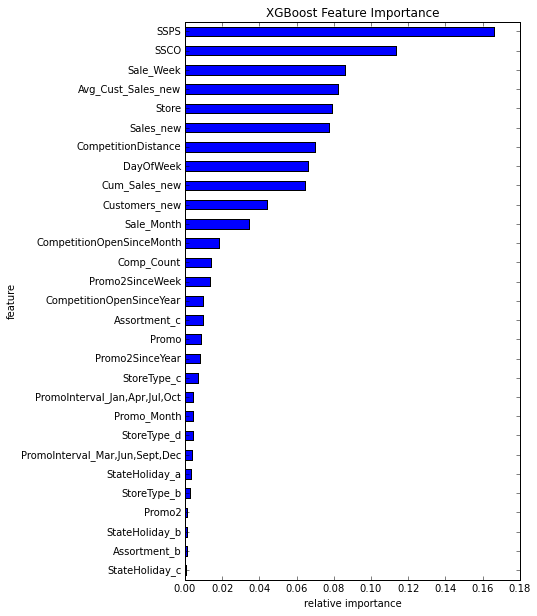

In [192]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [193]:
features2 = ['SSPS', 'SSCO', 'Sale_Week', 'Avg_Cust_Sales_new', 'Store', 'Sales_new', 'CompetitionDistance', 
       'DayOfWeek', 'Cum_Sales_new']



In [194]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features2], y_train)
dvalid = xgb.DMatrix(X_valid[features2], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996922	eval-rmspe:0.996917
[1]	train-rmspe:0.982138	eval-rmspe:0.982113
[2]	train-rmspe:0.940147	eval-rmspe:0.940080
[3]	train-rmspe:0.860855	eval-rmspe:0.860767
[4]	train-rmspe:0.749309	eval-rmspe:0.749396
[5]	train-rmspe:0.622550	eval-rmspe:0.623275
[6]	train-rmspe:0.499439	eval-rmspe:0.501719
[7]	train-rmspe:0.393593	eval-rmspe:0.398649
[8]	train-rmspe:0.311810	eval-rmspe:0.320721
[9]	train-rmspe:0.254733	eval-rmspe:0.268817
[10]	train-rmspe:0.219208	eval-rmspe:0.238289
[11]	train-rmspe:0.199680	eval-rmspe:0.222294
[12]	train-rmspe:0.190404	eval-rmspe:0.215884
[13]	train-rmspe:0.153951	eval-rmspe:0.214339
[14]	train-rmspe:0.150270	eval-rmspe:0.214641
[15]	train-rmspe:0.148693	eval-rmspe:0.215099
[16]	train-rmspe:0.147651	eval-rmspe:0.214798
[17]	train-rmspe:0.146393	eval-rmspe:0.214286
[18]	train-rmspe:0.146133	eval-rmspe:0.215290
[19]	train-rmspe:0.146113	eval-rmspe:0.215756
[20]	train-rmspe:0.145944	eval

In [195]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features2]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.201777


In [247]:
features3 = ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'Sale_Month', 'Sale_Week', 
       'DayOfWeek', 'Cum_Sales_new', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c', 'CompetitionOpen']


In [248]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features3], y_train)
dvalid = xgb.DMatrix(X_valid[features3], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996902	eval-rmspe:0.996896
[1]	train-rmspe:0.981991	eval-rmspe:0.981956
[2]	train-rmspe:0.939712	eval-rmspe:0.939618
[3]	train-rmspe:0.859996	eval-rmspe:0.859930
[4]	train-rmspe:0.748247	eval-rmspe:0.748561
[5]	train-rmspe:0.621861	eval-rmspe:0.623716
[6]	train-rmspe:0.499862	eval-rmspe:0.504311
[7]	train-rmspe:0.396408	eval-rmspe:0.405868
[8]	train-rmspe:0.317362	eval-rmspe:0.333971
[9]	train-rmspe:0.264736	eval-rmspe:0.289632
[10]	train-rmspe:0.233136	eval-rmspe:0.265231
[11]	train-rmspe:0.213662	eval-rmspe:0.253581
[12]	train-rmspe:0.205228	eval-rmspe:0.248873
[13]	train-rmspe:0.201967	eval-rmspe:0.249643
[14]	train-rmspe:0.200087	eval-rmspe:0.250161
[15]	train-rmspe:0.197267	eval-rmspe:0.250624
[16]	train-rmspe:0.196250	eval-rmspe:0.251036
[17]	train-rmspe:0.196570	eval-rmspe:0.251775
[18]	train-rmspe:0.196717	eval-rmspe:0.252270
[19]	train-rmspe:0.195685	eval-rmspe:0.253079
[20]	train-rmspe:0.195261	eval

In [249]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features3]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.235762


In [260]:
features = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Open',
       'Promo', 'Sale_Month',
       'Sale_Week', 'Weekend', 'SSPS', 'SSCO',
       'CompOpenedInYear', 'CompetitionOpen', 'Sales_new', 'Avg_Cust_Sales_new','Cum_Sales_new', 'Customers_new']



In [261]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996922	eval-rmspe:0.996917
[1]	train-rmspe:0.982138	eval-rmspe:0.982113
[2]	train-rmspe:0.940151	eval-rmspe:0.940083
[3]	train-rmspe:0.860850	eval-rmspe:0.860758
[4]	train-rmspe:0.749356	eval-rmspe:0.749442
[5]	train-rmspe:0.622607	eval-rmspe:0.623350
[6]	train-rmspe:0.499456	eval-rmspe:0.501763
[7]	train-rmspe:0.393417	eval-rmspe:0.398588
[8]	train-rmspe:0.311296	eval-rmspe:0.320720
[9]	train-rmspe:0.254125	eval-rmspe:0.268672
[10]	train-rmspe:0.218241	eval-rmspe:0.238175
[11]	train-rmspe:0.197901	eval-rmspe:0.222681
[12]	train-rmspe:0.188232	eval-rmspe:0.215847
[13]	train-rmspe:0.183389	eval-rmspe:0.212023
[14]	train-rmspe:0.182358	eval-rmspe:0.212050
[15]	train-rmspe:0.181717	eval-rmspe:0.212447
[16]	train-rmspe:0.181559	eval-rmspe:0.213109
[17]	train-rmspe:0.181624	eval-rmspe:0.213404
[18]	train-rmspe:0.180751	eval-rmspe:0.213377
[19]	train-rmspe:0.181092	eval-rmspe:0.213825
[20]	train-rmspe:0.180694	eval

In [262]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.199425


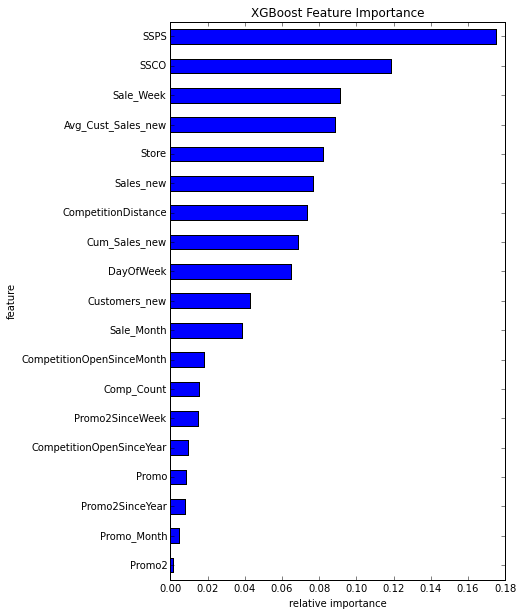

In [263]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [265]:
features

['Store',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Promo_Week',
 'Promo_Year',
 'Promo_Month',
 'Comp_Count',
 'DayOfWeek',
 'Open',
 'Promo',
 'Sale_Month',
 'Sale_Week',
 'Weekend',
 'SSPS',
 'SSCO',
 'CompOpenedInYear',
 'CompetitionOpen',
 'Sales_new',
 'Avg_Cust_Sales_new',
 'Cum_Sales_new',
 'Customers_new']

In [281]:
test.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Comp_Date',
       u'CompetitionOpen', u'Promo_Week', u'Promo_Year', u'Promo_Date',
       u'Promo_Month', u'Comp_Count', u'Id', u'DayOfWeek', u'Date', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'Sale_Month',
       u'Sale_Week', u'Sale_Since_Comp_Opened', u'Sale_Since_Promo_Started',
       u'SchoolHoliday2', u'Weekend', u'StoreType_b', u'StoreType_c',
       u'StoreType_d', u'Assortment_b', u'Assortment_c', u'StateHoliday_a',
       u'PromoInterval_Feb,May,Aug,Nov', u'PromoInterval_Jan,Apr,Jul,Oct',
       u'PromoInterval_Mar,Jun,Sept,Dec', u'SSPS', u'SSCO',
       u'CompOpenedInYear', u'Sales_new', u'Avg_Cust_Sales_new',
       u'Cum_Sales_new', u'Customers_new'],
      dtype='object')

In [284]:
test[test.Sales_new.isnull()].DayOfWeek

4        7
11       7
18       7
25       7
32       7
39       7
46       7
52       7
59       7
66       7
73       7
80       7
87       7
94       7
100      7
107      7
114      7
121      7
128      7
135      7
142      7
148      7
155      7
162      7
169      7
176      7
183      7
190      7
196      7
203      7
        ..
40839    7
40846    7
40852    7
40859    7
40866    7
40873    7
40880    7
40887    7
40894    7
40900    7
40907    7
40914    7
40921    7
40928    7
40935    7
40942    7
40948    7
40955    7
40962    7
40969    7
40976    7
40983    7
40990    7
40996    7
41003    7
41010    7
41017    7
41024    7
41031    7
41038    7
Name: DayOfWeek, dtype: int64

In [531]:
test.fillna(value=0, inplace=True) 

In [286]:
# Making predictions on the test set
dtest = xgb.DMatrix(test[features])
test_probs = gbm.predict(dtest)

In [290]:
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs), "Open": test["Open"]})

In [292]:
result['Sales'] = np.where((result['Open']==0), 0, result['Sales'])

In [296]:
result.drop('Open', axis=1, inplace = True)  

In [299]:
result.to_csv('/Users/jamieyachera/DAT9/DAT-9-HW/Project/JYSubmission.csv', index=False)

In [387]:
#Attempt 2
featuresnew = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Open',
       'Promo', 'Sale_Month',
       'Sale_Week', 'Weekend','StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec', 'SSPS', 'SSCO',
       'CompOpenedInYear', 'Sales_new', 'Avg_Cust_Sales_new','Cum_Sales_new', 'Customers_new']
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1
          }
num_boost_round = 300




In [388]:
X_train, X_valid = train_test_split(train, random_state=10)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[featuresnew], y_train)
dvalid = xgb.DMatrix(X_valid[featuresnew], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996921	eval-rmspe:0.996916
[1]	train-rmspe:0.982109	eval-rmspe:0.982082
[2]	train-rmspe:0.939986	eval-rmspe:0.939903
[3]	train-rmspe:0.860642	eval-rmspe:0.860528
[4]	train-rmspe:0.749159	eval-rmspe:0.749257
[5]	train-rmspe:0.622427	eval-rmspe:0.623318
[6]	train-rmspe:0.499540	eval-rmspe:0.502307
[7]	train-rmspe:0.393865	eval-rmspe:0.400113
[8]	train-rmspe:0.312038	eval-rmspe:0.323153
[9]	train-rmspe:0.255136	eval-rmspe:0.273191
[10]	train-rmspe:0.219641	eval-rmspe:0.244055
[11]	train-rmspe:0.198600	eval-rmspe:0.231087
[12]	train-rmspe:0.188732	eval-rmspe:0.225048
[13]	train-rmspe:0.184413	eval-rmspe:0.222324
[14]	train-rmspe:0.183072	eval-rmspe:0.220677
[15]	train-rmspe:0.182297	eval-rmspe:0.222310
[16]	train-rmspe:0.149231	eval-rmspe:0.223268
[17]	train-rmspe:0.147613	eval-rmspe:0.223881
[18]	train-rmspe:0.146880	eval-rmspe:0.224126
[19]	train-rmspe:0.145805	eval-rmspe:0.223268
[20]	train-rmspe:0.145158	eval

In [389]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[featuresnew]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.189151


In [442]:
test.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Comp_Date',
       u'CompetitionOpen', u'Promo_Week', u'Promo_Year', u'Promo_Date',
       u'Promo_Month', u'Comp_Count', u'Id', u'DayOfWeek', u'Date', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'Sale_Month',
       u'Sale_Week', u'Sale_Since_Comp_Opened', u'Sale_Since_Promo_Started',
       u'SchoolHoliday2', u'Weekend', u'StoreType_b', u'StoreType_c',
       u'StoreType_d', u'Assortment_b', u'Assortment_c', u'StateHoliday_a',
       u'PromoInterval_Feb,May,Aug,Nov', u'PromoInterval_Jan,Apr,Jul,Oct',
       u'PromoInterval_Mar,Jun,Sept,Dec', u'SSPS', u'SSCO',
       u'CompOpenedInYear', u'Sales_new', u'Avg_Cust_Sales_new',
       u'Cum_Sales_new', u'Customers_new'],
      dtype='object')

In [443]:
train.columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Comp_Date',
       u'CompetitionOpen', u'Promo_Week', u'Promo_Year', u'Promo_Date',
       u'Promo_Month', u'Comp_Count', u'DayOfWeek', u'Date', u'Sales',
       u'Customers', u'Open', u'Promo', u'StateHoliday', u'SchoolHoliday',
       u'Sale_Month', u'Sale_Week', u'Cum_Sales', u'Cum_Cust',
       u'Avg_Cust_Sales', u'Sale_Since_Comp_Opened',
       u'Sale_Since_Promo_Started', u'SchoolHoliday2', u'Weekend',
       u'StoreType_b', u'StoreType_c', u'StoreType_d', u'Assortment_b',
       u'Assortment_c', u'StateHoliday_a', u'StateHoliday_b',
       u'StateHoliday_c', u'PromoInterval_Feb,May,Aug,Nov',
       u'PromoInterval_Jan,Apr,Jul,Oct', u'PromoInterval_Mar,Jun,Sept,Dec',
       u'SSPS', u'SSCO', u'CompOpenedInYear', u'Sales_new',
       u'Avg_Cust_Sales_new', u'Cum_Sales_n

In [444]:
# Redoing how to handle missing variables (avg)

Customers_new_average = train['Customers_new'].mean()
Sales_new_average = train['Sales_new'].mean()
Avg_Cust_Sales_average = train['Avg_Cust_Sales_new'].mean()
Cum_Sales_new_average = train['Cum_Sales_new'].mean()

In [445]:
test.Avg_Cust_Sales_new.fillna(value=Avg_Cust_Sales_average, inplace=True) 
test.Cum_Sales_new.fillna(value=Cum_Sales_new_average, inplace=True) 
test.Sales_new.fillna(value=Sales_new_average, inplace=True) 
test.Customers_new.fillna(value=Customers_new_average, inplace=True) 

In [446]:
# Ten stores had a null of open.
test.fillna(value=0, inplace=True) 

In [447]:
test.sort().columns

Index([u'Store', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'Comp_Date',
       u'CompetitionOpen', u'Promo_Week', u'Promo_Year', u'Promo_Date',
       u'Promo_Month', u'Comp_Count', u'Id', u'DayOfWeek', u'Date', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'Sale_Month',
       u'Sale_Week', u'Sale_Since_Comp_Opened', u'Sale_Since_Promo_Started',
       u'SchoolHoliday2', u'Weekend', u'StoreType_b', u'StoreType_c',
       u'StoreType_d', u'Assortment_b', u'Assortment_c', u'StateHoliday_a',
       u'PromoInterval_Feb,May,Aug,Nov', u'PromoInterval_Jan,Apr,Jul,Oct',
       u'PromoInterval_Mar,Jun,Sept,Dec', u'SSPS', u'SSCO',
       u'CompOpenedInYear', u'Sales_new', u'Avg_Cust_Sales_new',
       u'Cum_Sales_new', u'Customers_new'],
      dtype='object')

In [448]:
test.sort

<bound method DataFrame.sort of        Store StoreType Assortment  CompetitionDistance  \
0          1         c          a                 1270   
1          1         c          a                 1270   
2          1         c          a                 1270   
3          1         c          a                 1270   
4          1         c          a                 1270   
5          1         c          a                 1270   
6          1         c          a                 1270   
7          1         c          a                 1270   
8          1         c          a                 1270   
9          1         c          a                 1270   
10         1         c          a                 1270   
11         1         c          a                 1270   
12         1         c          a                 1270   
13         1         c          a                 1270   
14         1         c          a                 1270   
15         1         c          a       

In [449]:
# Making predictions on the test set
dtest = xgb.DMatrix(test[featuresnew])
test_probs = gbm.predict(dtest)

In [459]:
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs), "Open": test["Open"]})
result['Sales'] = np.where((result['Open']==0), 0, result['Sales'])
result.drop('Open', axis=1, inplace = True)  
result.to_csv('/Users/jamieyachera/DAT9/DAT-9-HW/Project/JYSubmission2.csv', index=False)

In [460]:
#Attempt 3
featuresnew3 = ['Store', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 
       'Promo_Week', 'Promo_Year', 'Promo_Month',
       'Comp_Count', 'DayOfWeek', 'Open',
       'Promo', 'Sale_Month',
       'Sale_Week', 'Weekend','StateHoliday_a','StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_b',
       'Assortment_c', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec', 'SSPS', 'SSCO',
       'CompOpenedInYear', 'Sales_new', 'Avg_Cust_Sales_new','Cum_Sales_new', 'Customers_new']
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 12,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 100
          }
num_boost_round = 400



In [461]:
X_train, X_valid = train_test_split(train, random_state=100)
y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[featuresnew3], y_train)
dvalid = xgb.DMatrix(X_valid[featuresnew3], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996912	eval-rmspe:0.996912
[1]	train-rmspe:0.982104	eval-rmspe:0.982104
[2]	train-rmspe:0.940030	eval-rmspe:0.940031
[3]	train-rmspe:0.860704	eval-rmspe:0.860756
[4]	train-rmspe:0.749153	eval-rmspe:0.749462
[5]	train-rmspe:0.622508	eval-rmspe:0.623554
[6]	train-rmspe:0.499500	eval-rmspe:0.502334
[7]	train-rmspe:0.393383	eval-rmspe:0.398979
[8]	train-rmspe:0.311199	eval-rmspe:0.320167
[9]	train-rmspe:0.253345	eval-rmspe:0.266992
[10]	train-rmspe:0.216632	eval-rmspe:0.235871
[11]	train-rmspe:0.192759	eval-rmspe:0.219494
[12]	train-rmspe:0.182080	eval-rmspe:0.211916
[13]	train-rmspe:0.176153	eval-rmspe:0.208667
[14]	train-rmspe:0.173170	eval-rmspe:0.205267
[15]	train-rmspe:0.171816	eval-rmspe:0.205294
[16]	train-rmspe:0.135318	eval-rmspe:0.206136
[17]	train-rmspe:0.134374	eval-rmspe:0.205876
[18]	train-rmspe:0.133524	eval-rmspe:0.205548
[19]	train-rmspe:0.132683	eval-rmspe:0.205534
[20]	train-rmspe:0.130201	eval

In [462]:
#"Validating"
yhat = gbm.predict(xgb.DMatrix(X_valid[featuresnew3]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.187163


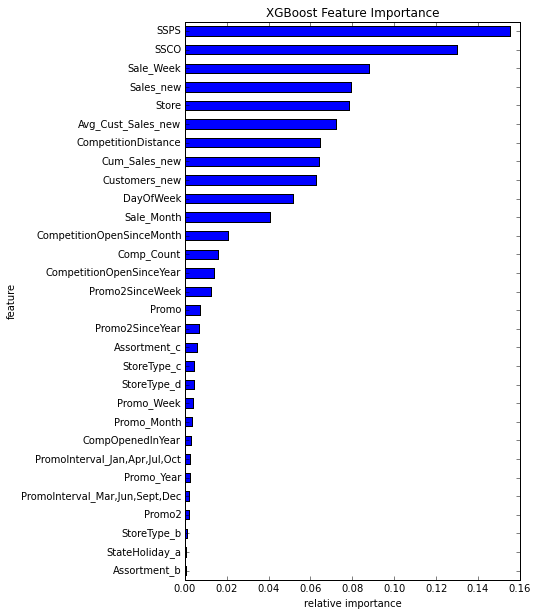

In [463]:
create_feature_map(featuresnew3)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

In [464]:
# Making predictions on the test set
dtest = xgb.DMatrix(test[featuresnew3])
test_probs = gbm.predict(dtest)
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv('/Users/jamieyachera/DAT9/DAT-9-HW/Project/JYSubmission3.csv', index=False)
result2 = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs), "Open": test["Open"]})
result2['Sales'] = np.where((result2['Open']==0), 0, result2['Sales'])
result2.drop('Open', axis=1, inplace = True)  
result2.to_csv('/Users/jamieyachera/DAT9/DAT-9-HW/Project/JYSubmission3b.csv', index=False)

In [483]:
# How does this compare to Linear Regression?
# Linear Regression Models using Sales

X = train[featuresnew]
y = np.log1p(train.Sales)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
y_test2 = np.expm1(y_test)
y_pred2 = np.expm1(y_pred)
rmspe(y_test2,y_pred2)


0.23262857520518565

In [532]:
X = train[featuresnew]
y = np.log1p(train.Sales)
linreg = LinearRegression()
linreg.fit(X, y)

XT = test[featuresnew]
y_pred = linreg.predict(XT)
y_pred2 = np.expm1(y_pred)

results = pd.DataFrame({"Id": test["Id"], 'Sales': y_pred2,"Open": test["Open"]})
results['Sales'] = np.where((results['Open']==0), 0, results['Sales'])
results.drop('Open', axis=1, inplace = True)  
results.to_csv('/Users/jamieyachera/DAT9/DAT-9-HW/Project/JYSubmissionLR.csv', index=False)

In [536]:
X = train[featuresnew]
y = train.Sales
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print rmspe(y_test,y_pred)
resid = y_test - y_pred
results = pd.DataFrame({"Id": test["Id"], 'Residual': resid})

0.182891468468


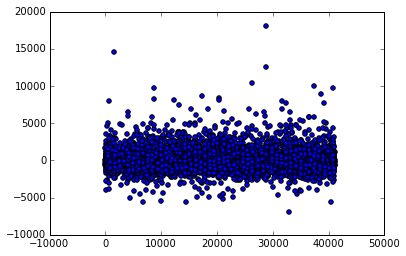

In [535]:
plt.scatter(results.Id, results.Residual)

In [542]:
X = train[featuresnew]
y = np.log1p(train.Sales)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)
print rmspe(y_test,y_pred)
resid = y_test - y_pred
results = pd.DataFrame({"Id": test["Id"], 'Residual': resid})

0.232628575205


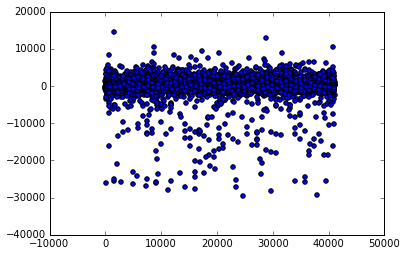

In [543]:
plt.scatter(results.Id, results.Residual)